### STOCK PREDICTIONS using LINEAR REGRESSION and LSTM

In [1]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from datetime import datetime
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Retrieve data
ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start='2020-01-01', end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Create connection to sqlite
conn = sqlite3.connect(':memory:')

# Store data in table
data.to_sql('stock_prices', conn, if_exists='replace', index=True)


1158

### STOCK Predictions using LINEAR REGRESSION MODEL with  SQL LITE

Linear regression models the relationship between a dependent variable and one or more independent variables using a linear equation. For stock prediction, it might predict tomorrow's price based on a linear combination of today's prices, volumes, and other financial indicators.

Pros: Simplicity, Interpretability
Cons: Assumes Linearity, Sensitive to Noise

In [4]:
# Retrieve data from sqlite
query = "SELECT* FROM stock_prices"
df = pd.read_sql(query, conn)
df['Date'] = pd.to_datetime(df['Date'])


In [5]:
# Normalize and standardize the 'close' prices
df['Close'] = StandardScaler().fit_transform(df[['Close']])


In [6]:
# Train a linear regression model
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

df.head()

R-squared: 0.9993058570521063


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,-2.006715,72.960464,135480400
1,2020-01-03,74.287498,75.144997,74.125000,-2.026968,72.251144,146322800
2,2020-01-06,73.447502,74.989998,73.187500,-2.010530,72.826851,118387200
3,2020-01-07,74.959999,75.224998,74.370003,-2.020309,72.484344,108872000
4,2020-01-08,74.290001,76.110001,74.290001,-1.987018,73.650352,132079200


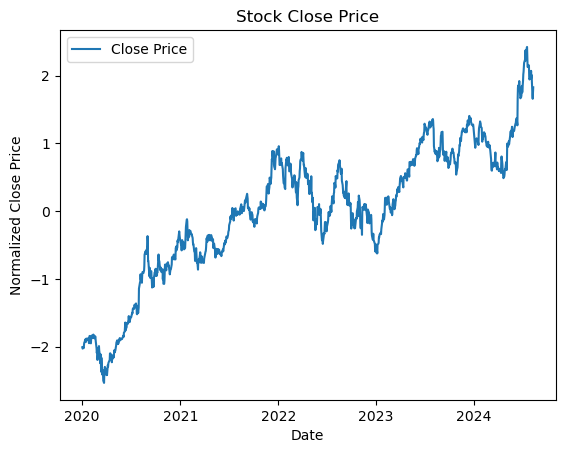

In [7]:
# Create a line chart of the 'Close' price
plt.plot(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Stock Close Price')
plt.legend()
plt.show()

### Avoid look ahead bias
 1. Model already has been fed H, L, O --> so it knows that the close is going to be in between H and L
 2. Hence the margin of error is low.
 3. You cannot possibly know the highest daily high and lowest daily low as long as the trading day is still active.
 3. It always good to use lag for predicting time series.

###  STOCK PREDICTIONS using  LSTM

LSTM is a type of recurrent neural network (RNN) particularly good at learning from sequences (such as time series data). It can capture long-term dependencies and patterns in time series data, making it suitable for tasks like stock price predictions.

Pros: Sequence Memory, Flexibility
Cons: Complexity, Overfitting

In [8]:
stock = yf.Ticker("AAPL")
stock = stock.history(period='2y')


In [9]:
stock.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-08-09 00:00:00-04:00,162.410382,164.192721,161.647935,163.301544,63135500,0.0,0.0
2022-08-10 00:00:00-04:00,166.034429,167.678142,165.262085,167.579132,70170500,0.0,0.0
2022-08-11 00:00:00-04:00,168.391102,169.311983,166.539458,166.836517,57149200,0.0,0.0
2022-08-12 00:00:00-04:00,168.153463,170.480392,167.737572,170.411087,68039400,0.0,0.0
2022-08-15 00:00:00-04:00,169.836762,171.688406,169.668432,171.490372,54091700,0.0,0.0
2022-08-16 00:00:00-04:00,171.084424,172.005305,169.975420,171.331970,56377100,0.0,0.0
2022-08-17 00:00:00-04:00,171.074506,174.421325,170.876471,172.837036,79542000,0.0,0.0
2022-08-18 00:00:00-04:00,172.044880,173.183588,171.421058,172.440948,62290100,0.0,0.0
2022-08-19 00:00:00-04:00,171.331937,172.034976,169.628816,169.836761,70346300,0.0,0.0


In [10]:
del stock['Dividends']
del stock['Stock Splits']

In [11]:
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-09 00:00:00-04:00,162.410382,164.192721,161.647935,163.301544,63135500
2022-08-10 00:00:00-04:00,166.034429,167.678142,165.262085,167.579132,70170500
2022-08-11 00:00:00-04:00,168.391102,169.311983,166.539458,166.836517,57149200
2022-08-12 00:00:00-04:00,168.153463,170.480392,167.737572,170.411087,68039400
2022-08-15 00:00:00-04:00,169.836762,171.688406,169.668432,171.490372,54091700


<Axes: xlabel='Date'>

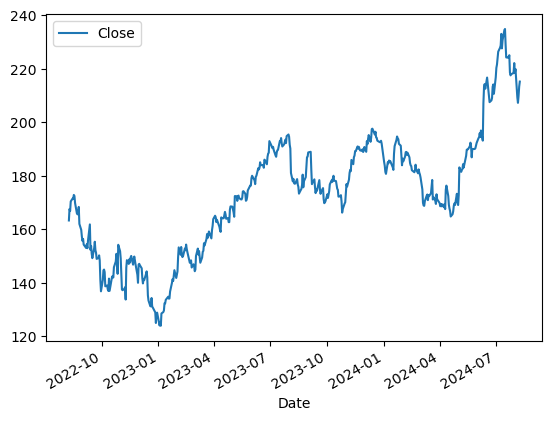

In [12]:
stock.plot.line(y="Close")

In [13]:
stock["Next Days Close"] = stock['Close'].shift(-1)

In [14]:
stock.tail()

,Open,High,Low,Close,Volume,Next Days Close
Date,,,,,,
2024-08-05 00:00:00-04:00,199.089996,213.500000,196.000000,209.270004,119548600,207.229996
2024-08-06 00:00:00-04:00,205.300003,209.990005,201.070007,207.229996,69660500,209.820007
2024-08-07 00:00:00-04:00,206.899994,213.639999,206.389999,209.820007,63516400,213.309998
2024-08-08 00:00:00-04:00,213.110001,214.199997,208.830002,213.309998,44598400,215.169998
2024-08-09 00:00:00-04:00,212.080002,215.735001,211.979996,215.169998,12611155,NaN


In [15]:
stock['change'] = (stock['Next Days Close'] > stock['Close']).astype(int)


In [16]:
# Checking most current prices

stock.tail()  

,Open,High,Low,Close,Volume,Next Days Close,change
Date,,,,,,,
2024-08-05 00:00:00-04:00,199.089996,213.500000,196.000000,209.270004,119548600,207.229996,0
2024-08-06 00:00:00-04:00,205.300003,209.990005,201.070007,207.229996,69660500,209.820007,1
2024-08-07 00:00:00-04:00,206.899994,213.639999,206.389999,209.820007,63516400,213.309998,1
2024-08-08 00:00:00-04:00,213.110001,214.199997,208.830002,213.309998,44598400,215.169998,1
2024-08-09 00:00:00-04:00,212.080002,215.735001,211.979996,215.169998,12611155,NaN,0


In [17]:
# Set up look back window for new model using LSTM (LongShortTermMemory)
# begining of new model coding

import numpy as np
def look_back_period(X, y, look_back_window=20):
    X_lstm, y_lstm, = [],[]
    for i in range(len(X)- look_back_window):
        X_lstm.append(X[i:i+look_back_window])
        y_lstm.append(y[i+look_back_window])
    return np.array(X_lstm), np.array(y_lstm)


In [18]:
# Drop rows with NaN target values
stock = stock.dropna(subset=['Next Days Close', 'change'])

#dropped 'Next Days Close' because it is not needed in new model
stock = stock.drop(columns = "Next Days Close")

# Split our preprocessed data into our features and target arrays
y = stock['change']
X = stock.drop(columns=['change'])

# Preserve the index of the original DataFrame
original_index = X.index

In [19]:
# Normalize data:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Scaling data for LSTM lookback
# Creates dataset suitable for training a model that expects a sequence of data points

X_scaled, y = look_back_period(X_scaled, y)

In [21]:
X_scaled.shape, y.shape

((483, 20, 5), (483,))

In [22]:
#split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# original code 
# Rebuild X_test DataFrame to restore index information
#X_test_df = pd.DataFrame(X_test, index=original_index[-len(X_test):], columns=X.columns)

In [ ]:
# Define the model this was original model
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
#])

In [23]:
#import LSTM for layers and Sequential for new model
# LSTM is used for time series data 

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [24]:
X_train.shape

(386, 20, 5)

In [25]:
# using tanh activation, its better suited for stock market non-linearity
# dropout 0.2 helps with over fitting

model = Sequential()

model.add(LSTM(units=50, activation="tanh", return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))

model.add(LSTM(units=30,return_sequences=True, activation="tanh",))
model.add(Dropout(0.2))

model.add(LSTM(units=10, activation="tanh"))

model.add(Dense(1, activation="sigmoid"))


/Users/keycaughey/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=10)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4641 - loss: 0.6994 - val_accuracy: 0.4231 - val_loss: 0.7034
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5738 - loss: 0.6888 - val_accuracy: 0.4231 - val_loss: 0.7002
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4831 - loss: 0.6966 - val_accuracy: 0.4231 - val_loss: 0.7083
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5397 - loss: 0.6896 - val_accuracy: 0.4231 - val_loss: 0.7011
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5233 - loss: 0.6912 - val_accuracy: 0.4231 - val_loss: 0.7027
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5884 - loss: 0.6863 - val_accuracy: 0.4231 - val_loss: 0.7035
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5359 - loss: 0.6866 - val_accuracy: 0.4231 - val_loss: 0.7149
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5343 - loss: 0.6948 - val_accuracy: 0.4231 - val_loss

In [28]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {model_loss}, Test Accuracy: {model_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.7388
Test Loss: 0.7211968302726746, Test Accuracy: 0.5154638886451721


In [29]:
# Make predictions
predictions = model.predict(X_test).round().flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [30]:
# Create a DataFrame for predictions with the index of X_test_df

predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

In [31]:
precision_score(y_test,predictions)

0.6590909090909091

In [32]:
# checking to see if model is overtrained
# Looping through epochs to get data 

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
num_epochs = 50
x_axis = [i for i in range(num_epochs)]


In [33]:
# Importing dependencies for overtrain analysis chart

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [34]:
# Creating function for overtrain analysis chart

def analysis_plot(x,train_data, val_data):
    plt.figure(figsize=(12,6))
    plt.plot(x,train_data,label = "train data")
    plt.plot(x,val_data, label = "val data")
    plt.legend()
    plt.plot();

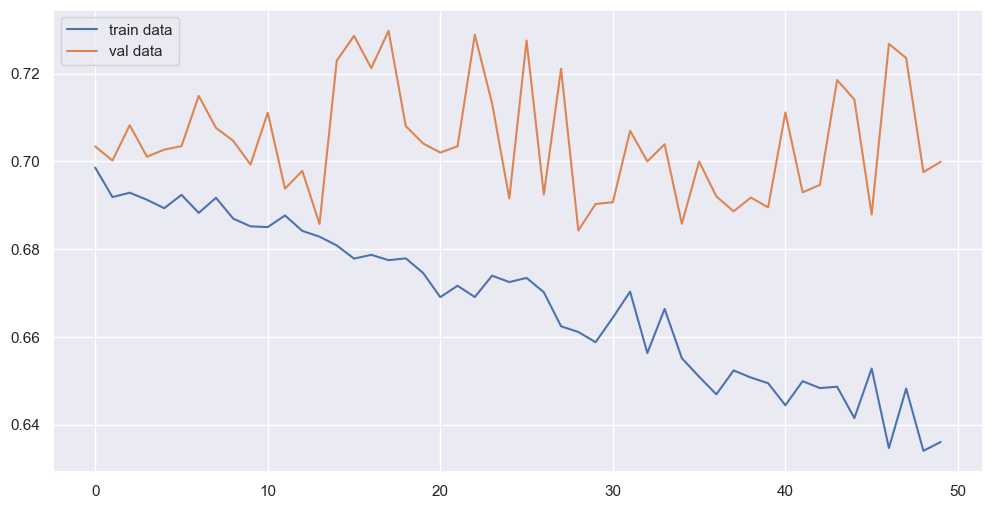

In [35]:
# Val data shows its overfitting the data 
# train data shows model is getting better at minimizing loss
# Might reduce epochs to 80

analysis_plot(x=x_axis,train_data = train_loss, val_data=val_loss)

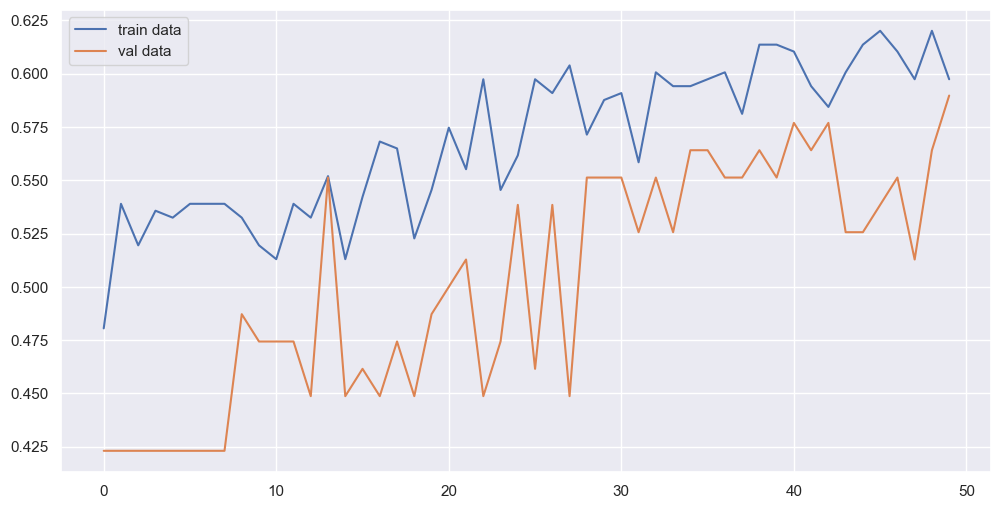

In [36]:

# Train data shows its learning and improving on the data over time
# Val data is flat , may be overfitting the data 

analysis_plot(x=x_axis,train_data = train_acc, val_data = val_acc)

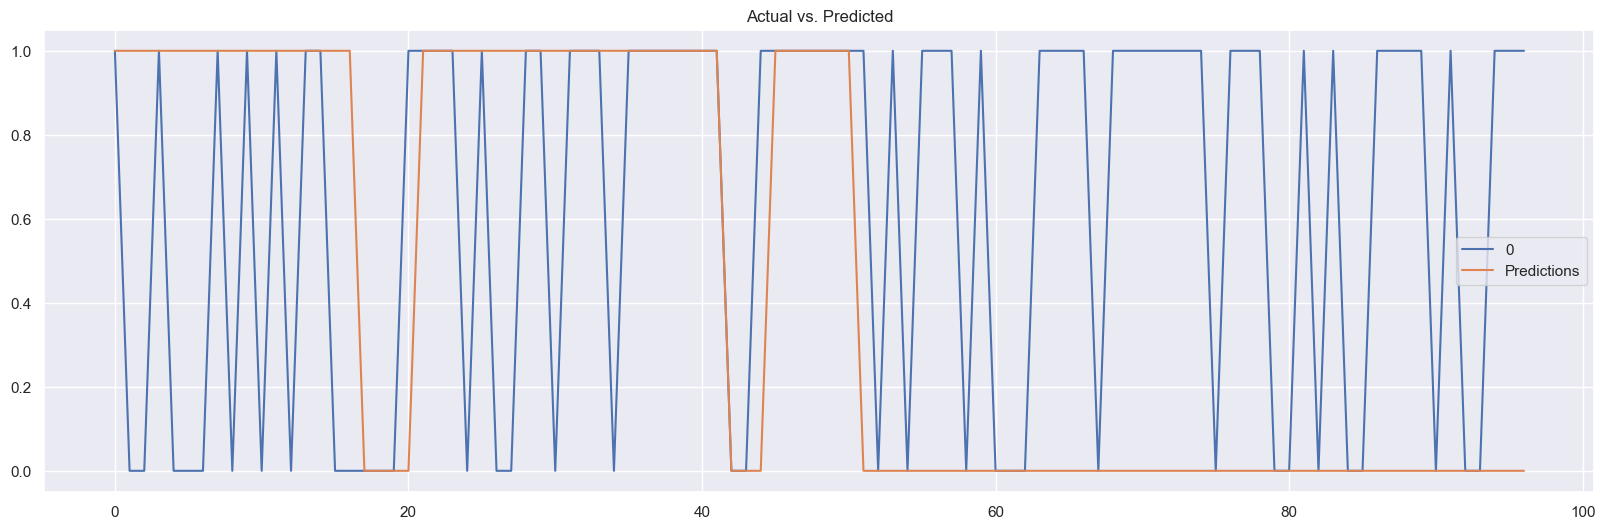

In [37]:
# Combine actual values and predictions
# Orange is predicted, Blue is actual
combined = pd.concat([pd.Series(y_test), predictions_df], axis=1)

# Plot the combined DataFrame
# plt.figure(figsize = (20,6))
combined.plot(title='Actual vs. Predicted', figsize=(20,6))
# plt.figure(figsize=(20,6))
plt.show()

In [38]:
# ? What does this column do ?

combined.columns

Index([0, 'Predictions'], dtype='object')

In [39]:

# Prepare latest data for prediction
# Data is scaled 

look_back_window = 20  # Ensure this matches our function parameter
latest_data = X_scaled[-1].reshape(1, look_back_window, X_scaled.shape[2])
latest_data_df = pd.DataFrame(latest_data[0], columns=X.columns)

print(latest_data_df)

        Open      High       Low     Close    Volume
0   2.602843  2.568954  2.429256  2.429733 -0.035760
1   2.493511  2.580017  2.558314  2.561308 -0.510244
2   2.828146  2.783126  2.753896  2.732313 -0.120344
3   2.762636  2.740646  2.720191  2.750920 -0.909394
4   2.516970  2.527801  2.467840  2.487768 -0.335348
5   2.553710  2.482666  2.274032  2.279550  0.018099
6   2.312029  2.321594  2.318825  2.285309 -0.668688
7   2.408966  2.364959  2.310399  2.269804 -0.707321
8   2.292109  2.327789  2.292215  2.316320 -1.042577
9   2.275732  2.233093  2.046074  2.029689 -0.155071
10  2.051313  2.058304  1.934756  1.983172 -0.577579
11  2.041133  1.998123  1.996402  2.003994 -0.975822
12  1.964114  1.989715  1.984871  2.016399 -1.190994
13  2.062822  2.035293  2.001281  2.041207 -0.974094
14  2.162416  2.189728  2.201299  2.186517 -0.632695
15  2.292109  2.218933  2.041196  2.021715 -0.125644
16  2.061051  2.268494  2.071797  2.088167  1.626301
17  1.173116  1.733063  1.108964  1.619013  2.

In [40]:

# Prepare latest data for prediction
latest_data = stock.drop(columns=['change']).iloc[-look_back_window:]  # Get the last look_back_window rows
latest_data_scaled = scaler.transform(latest_data)  # Scale the data
latest_data_reshaped = latest_data_scaled.reshape(1, look_back_window, latest_data_scaled.shape[1])  # Reshape to (1, look_back_window, num_features)


In [41]:

# Make prediction for the next day
next_day_prediction = model.predict(latest_data_reshaped).round().flatten()[0]

# Interpret the prediction
if next_day_prediction == 1:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The model predicts that the stock price will decrease the next day.


In [42]:
precision = precision_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
r_squared = r2_score(y_test, predictions)


print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'R-squared: {r_squared}')


Precision: 0.6590909090909091
Accuracy: 0.5154639175257731
Recall: 0.47540983606557374
F1 Score: 0.5523809523809523
R-squared: -1.076047358834244


Precision is the ratio of true positive predictions to the total number of positive predictions (both true and false positives).

Accuracy is the ratio of correct predictions (both true positives and true negatives) to the total number of predictions.Low accuracy suggests that the model isn't very reliable overall.

Recall (or sensitivity) is the ratio of true positive predictions to the total number of actual positives (true positives and false negatives).Low recall suggests that the model misses a significant number of actual stock price increases (high false negative rate).

F1 Score is the harmonic mean of precision and recall, providing a single metric that balances the two. It ranges from 0 to 1, where 1 indicates perfect precision and recall. However, given that both precision and recall are not very high, the F1 score reflects the model's overall mediocre performance.

R-squared (R²) measures the proportion of variance in the dependent variable (stock price change) that is predictable from the independent variables (features in your model). Negative R-squared values suggest that the model is not fitting the data well and may even be introducing more error than a simple average prediction.




[*********************100%%**********************]  11 of 11 completed


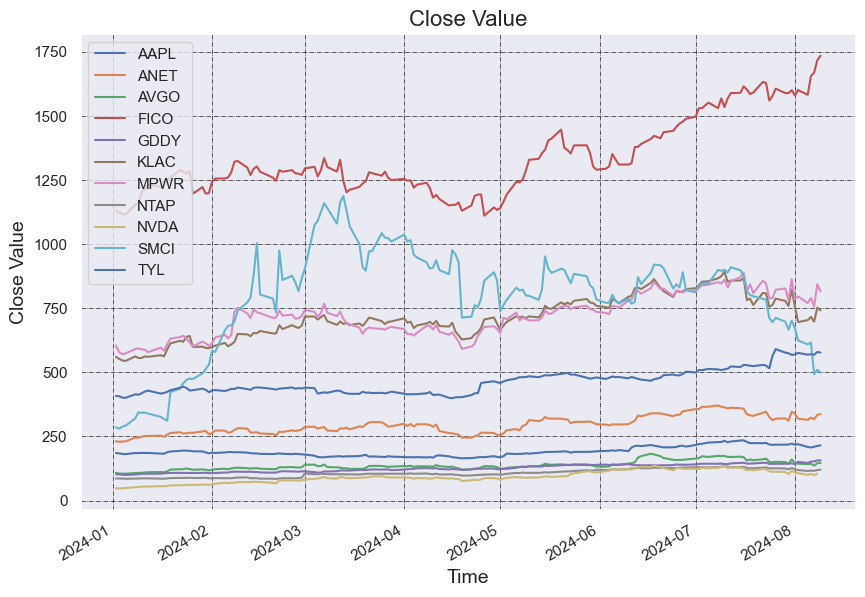

In [44]:
# Original graph 
# Define the ticker list
import pandas as pd
tickers_list = ['SMCI', 'NVDA', 'ANET', 'NTAP', 'AVGO', 'KLAC', 'FICO', 'GDDY', 'MPWR', 'TYL','AAPL']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2024-1-1')['Close']

# Plot all the close prices
((data.plot(figsize=(10, 7))))
plt.legend()
plt.title("Close Value", fontsize=16)

# Define the labels
plt.ylabel('Close Value', fontsize=14)
plt.xlabel('Time', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()